In [2]:
'''Shallow neural networks trained on the ECG5000 Data Set (Jupyter notebook version)'''
import numpy as np
from sklearn.model_selection import train_test_split

# read and process data
def get_data(RANDOM_SEED=22):
    np.random.seed(RANDOM_SEED)

    train_data = np.genfromtxt('ECG5000_TRAIN.txt')
    test_data = np.genfromtxt('ECG5000_TEST.txt')
    wdata = np.vstack([train_data, test_data])

    for i in range(wdata.shape[0]):
        if wdata[i,0] > 1.0:
            wdata[i,0] = 1.0
        else:
            wdata[i,0] = 0.0

    np.random.shuffle(wdata)

    normal_data = wdata[wdata[:,0]==0.0,:]
    abnormal_data = wdata[wdata[:,0]==1.0,:]

    data = wdata[:,1:]
    labels = wdata[:,0]
   
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.9, random_state=RANDOM_SEED)

    min_val = np.min(train_data)
    max_val = np.max(train_data)
    X_train = (train_data-min_val)/(max_val-min_val)
    X_test = (test_data-min_val)/(max_val-min_val)
    y_train = train_labels
    y_test = test_labels

    print('training input data shape: ', X_train.shape)
    print('testing input data shape: ', X_test.shape)

    #normal_train_data = train_data[y_train==True]
    #normal_test_data = test_data[y_test==True]
    #abnormal_train_data = X_train[y_train==False]
    #abnormal_test_data = X_test[y_test==False]
    #print(normal_train_data.shape)
    #print(abnormal_train_data.shape)

    return X_train, y_train, X_test, y_test


In [3]:
# helper functions for implementing the perturbations used in MPGD (see Section 3 of the paper for full details)
import numpy as np
import torch
from scipy.optimize import fsolve
from scipy.special import gamma as Gamma

# define the Thaler map
def Thaler_map(x, gamma):
  return ((x**(1-gamma) + (1+x)**(1-gamma) - 1)**(1/(1-gamma))) % 1

# define the chi_j 
def chi_func(x, x_star, p, seed):
  np.random.seed(seed)
  if x <= x_star:
    return 1.0
  else: 
    return 2*np.random.binomial(1,p,1)[0] - 1

# define v
def v_func(x, x_star, eta, gamma):
  alpha = 1/gamma
  if x <= x_star:
    return eta * ((1-2**(gamma-1))**(-gamma)) * ( (alpha**alpha)*(1-gamma)*Gamma(1-alpha)*np.cos(alpha*np.pi/2)/(2**(1-gamma)-1) )**(-gamma)
  else:
    return (eta * ((1-2**(gamma-1))**(-gamma)) * ( (alpha**alpha)*(1-gamma)*Gamma(1-alpha)*np.cos(alpha*np.pi/2)/(2**(1-gamma)-1) )**(-gamma))/(1-2**(1-gamma))

# define the observables v^{(k)} 
def obs_v(x_0, p, T, gamma, eta=1.0, seed=1234):
  y = x_0
  def func(x, gamma=gamma):
   return x**(1-gamma) + (1+x)**(1-gamma) - 2
  x_star =  fsolve(func, (0.01))[0]
  chi_i = chi_func(x=x_0, x_star=x_star, p=p, seed=seed) 
  v_0 = chi_i * v_func(y, x_star=x_star, eta=eta, gamma=gamma)
  v_list = []
  v_list.append(v_0)

  for i in range(T):
    y = Thaler_map(y, gamma=gamma)
    chi_i = chi_i * chi_func(x=y, x_star=x_star, p=p, seed=seed)
    v_new = v_func(x = y, x_star=x_star, eta=eta, gamma=gamma)
    v = chi_i * v_new
    v_list.append(v)
  return v_list

# define initial conditions following Gottwald-Melbourne (2021)
def init_data(gamma, seed=1234):
  np.random.seed(seed)
  x = np.random.uniform()
  for i in range(10000):
    x = Thaler_map(x, gamma=gamma)
  x_0 = x
  return x_0

# construct higher dimensional versions of the v^{(k)} (to be compatible with the shape of the parameters)
def obs_v_dim(p, T, gamma, param, eta=1.0, seed=1234):
  dim = torch.numel(param)
  obs_vec = torch.zeros((dim,T+1))
  for i in range(dim):
    x0 = init_data(gamma,i+seed) 
    obs_vec[i, :] = torch.tensor(obs_v(x0, p, T, gamma, eta=eta, seed=i+seed))
  if len(param.size()) == 1:
    return obs_vec.view(T+1, param.shape[0]) 
  elif len(param.size()) == 2:
    return obs_vec.view(T+1, param.shape[0], param.shape[1])
  elif len(param.size()) == 3:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2])
  elif len(param.size()) == 4:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2], param.shape[3])
  elif len(param.size()) == 5:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2], param.shape[3], param.shape[4])
  else:
    print('invalid shape!')

# construct higher dimensional versions of the observables for the MPGD variant (see Eq. (11) in the paper)
def diff_obs_v_dim(p, T, gamma, param, eta=1.0, seed=1234):
  dim = torch.numel(param)
  obs_vec = torch.zeros((dim,T+1))
  for i in range(dim):
    x0 = init_data(gamma,i+seed) 
    x00 = init_data(gamma,i+100*seed) 
    obs_vec[i, :] = torch.tensor( np.array(obs_v(x0, p, T, gamma, eta=eta, seed=i+seed)) - np.array(obs_v(x00, p, T, gamma, eta=eta, seed=i+seed)) )
  if len(param.size()) == 1:
    return obs_vec.view(T+1, param.shape[0]) 
  elif len(param.size()) == 2:
    return obs_vec.view(T+1, param.shape[0], param.shape[1])
  elif len(param.size()) == 3:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2])
  elif len(param.size()) == 4:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2], param.shape[3])
  elif len(param.size()) == 5:
    return obs_vec.view(T+1, param.shape[0], param.shape[1], param.shape[2], param.shape[3], param.shape[4])
  else:
    print('invalid shape!')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
import statistics

# get and process data
X_train, y_train, X_test, y_test = get_data()

BATCH_SIZE = X_train.shape[0] #equal training set size for full batch GD
print('batch size: ', BATCH_SIZE)

dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float).reshape(-1,1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)
test_target = torch.tensor(y_test, dtype=torch.float).reshape(-1,1)

# define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(140, 32)  # input layer
        self.fc2 = nn.Linear(32, 32) # hidden layer 
        self.last = nn.Linear(32, 1)  # ouput layer
        self.layers = [self.fc1, self.fc2]

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = torch.sigmoid(x)
        x = torch.sigmoid(self.last(x))
        return x.view(-1)

# implement various GD schemes: vanilla GD (baseline), GD with Gaussian perturbations, MPGD, MPGD variant Eq. (11) in the paper
def train(X_train, y_train, X_test, y_test, option=0, start_perturb=0, perturb_level=[0.0,0.0], beta=0.5, gamma=0.65, epochs=1000, lr=0.01, mom=0.0, seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_default_tensor_type(torch.DoubleTensor)

    if torch.cuda.device_count() > 0:
      device = torch.device('cuda')
      print("Connected to a GPU")
    else:
      print("Using the CPU")
      device = torch.device('cpu')

    net = Net().to(device)

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mom) 

    criterion = nn.BCELoss().to(device) 

    gamma = gamma #gamma is in (1/2,1)
    beta = beta #beta is in [-1,1]
    p = 0.5*(1+beta)
    
    total_params = sum(p.numel() for p in net.parameters())
    print('Number of trainable parameters: ', total_params)

    count = 0
    loss_list = []
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []
    train_acc_hist = []

    for epoch in range(epochs):
        net.train()
        inputs = Variable(torch.from_numpy(X_train)).to(device) 
        targets = Variable(torch.from_numpy(y_train)).to(device)
        outputs = net(inputs) 

        if epoch >= start_perturb and epoch < 500: #stop injecting perturbations after 500 epochs
          # simulate perturbations
          if option == 1 and epoch == start_perturb:
            p_vec_list = []
            for param in net.parameters():
              p_vec = obs_v_dim(p, epochs, gamma, param.data, seed=123456+seed)
              p_vec_list.append(p_vec)
          if option == 3 and epoch == start_perturb:
            p_vec_list = []
            for param in net.parameters():
              diff_p_vec = diff_obs_v_dim(p, epochs, gamma, param.data, seed=123456+seed)
              p_vec_list.append(diff_p_vec)

          # adding the perturbations/regularization to GD (for option > 0)
          reg = 0.0
          if option == 0: #baseline
            loss = criterion(outputs, targets)
          elif option == 1 or option == 3: #inject our perturbations (different for all parameters in all layers)
            param_count = 0
            for param in net.parameters():
              if param.requires_grad:
                p_perturb = p_vec_list[param_count]
                reg += (perturb_level[0] * (p_perturb[count].to(device) * param).sum() + perturb_level[1] * (p_perturb[count].to(device) * param * param).sum()/2) 
                param_count += 1
            loss = criterion(outputs, targets) + (lr**gamma) * reg / lr
          elif option == 2: #replace the perturbations with uncorrelated Gaussians instead for all parameters
            param_count = 0
            for param in net.parameters():
              if param.requires_grad:
                reg += perturb_level[0] * torch.matmul(torch.randn(param.shape).to(device), param.T).sum() + perturb_level[1] * (torch.randn(param.shape).to(device) * param * param).sum()/2
                param_count += 1
            loss = criterion(outputs, targets) + reg
          else:
            print('invalid option!')

          count += 1

        else:
          loss = criterion(outputs, targets)
          
        # collecting performance data at each epoch
        loss_list.append(criterion(outputs, targets).cpu().detach().numpy())
        
        loss.backward()        
        optimizer.step()
        optimizer.zero_grad()
            
        # evaluate
        net.eval()
        y_pred = net(Variable(torch.from_numpy(X_test).to(device)) ) 
        y_pred_train = net(Variable(torch.from_numpy(X_train)).to(device) )
        test_target = Variable(torch.from_numpy(y_test).to(device) )
        test_loss = criterion(y_pred, test_target) #the orignal test loss (without the perturbations)
        
        y_pred = y_pred.cpu().detach().numpy()
        y_pred[y_pred>=0.5] = 1.0
        y_pred[y_pred<0.5] = 0.0
        
        y_pred_train = y_pred_train.cpu().detach().numpy()
        y_pred_train[y_pred_train>=0.5] = 1.0
        y_pred_train[y_pred_train<0.5] = 0.0

        train_loss_hist.append(loss.cpu().detach().numpy())
        test_loss_hist.append(test_loss.cpu().detach().numpy())
        test_acc_hist.append(accuracy_score(y_test, y_pred))
        train_acc_hist.append(accuracy_score(y_train, y_pred_train))

    return net, train_loss_hist, test_loss_hist, test_acc_hist, train_acc_hist

# run the experiments 
def run_exp(option=0, lr=0.01, epochs=1000, start_perturb=0, gamma=0.6, beta=0.5, sigma=0.0, mu=0.0, n_run=5):
    list0 = []
    diff0 = []
    listacc = []
    for i in range(n_run):
        net0, train_loss_hist0, test_loss_hist0, test_acc_hist0, train_acc_hist0 = train(X_train, y_train, X_test, y_test, start_perturb=start_perturb, gamma=gamma, beta=beta, perturb_level=[sigma, mu], epochs=epochs, option=option, lr=lr, mom=0.0, seed=1+i)
        listacc.append(test_acc_hist0)
        list0.append(test_acc_hist0[-1]) 
        diff0.append(train_acc_hist0[-1]-test_acc_hist0[-1])
    print('===========> Option: ', option)
    if option == 1 or option == 3:
        print('gamma: ', gamma, ', beta: ', beta, ', mu: ', mu, ', sigma: ', sigma)
    elif option == 2:
        print('sigma: ', sigma, ', mu: ', mu)
    print('test accs: ', list0)
    print('acc gaps: ', diff0)
    mean_acc = np.array(np.mean(listacc, axis=0))
    print('Average test acc: ',  statistics.mean(list0) )
    print('Average acc gap: ',  statistics.mean(diff0) )
    print('Std dev of test acc: ', statistics.stdev(list0))
    print('Std dev of acc gap: ', statistics.stdev(diff0))
    print('Maximum test acc: ', max(list0))
    print('Minimum test acc: ', min(list0))
    print('Maximum acc gap: ', max(diff0))
    print('Minimum acc gap: ', min(diff0))
    print('--------------------------------------')
    return mean_acc

training input data shape:  (500, 140)
testing input data shape:  (4500, 140)
batch size:  500


In [5]:
########################################## main ###########################################

lr = 0.05
epochs = 1000
n_run = 5

print('=============== Using lr of ', lr, ' and run for ', epochs, ' epochs ============== ')

# baseline
print('==== baseline (vanilla GD) ===== ')
mean_acc_baseline = run_exp(option=0, lr=lr, epochs=epochs, start_perturb=0, n_run=n_run)


# GD with the perturbations replaced with uncorrelated Gaussian vectors
print('==== GD with Gaussian perturbations ===== ')
sigma = 0.2
mu = 0.2
mean_acc_gaussian = run_exp(option=2, lr=lr, epochs=epochs, start_perturb=0, sigma=sigma, mu=mu, n_run=n_run)

=============== Using lr of  0.05  and run for  1000  epochs ============== 
==== baseline (vanilla GD) ===== 
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  0
test accs:  [0.5837777777777777, 0.5837777777777777, 0.5837777777777777, 0.5837777777777777, 0.5837777777777777]
acc gaps:  [0.00022222222222223476, 0.00022222222222223476, 0.00022222222222223476, 0.00022222222222223476, 0.00022222222222223476]
Average test acc:  0.5837777777777777
Average acc gap:  0.00022222222222223476
Std dev of test acc:  0.0
Std dev of acc gap:  0.0
Maximum test acc:  0.5837777777777777
Minimum test acc:  0.5837777777777777
Maximum acc gap:  0.00022222222222223476
Minimum acc gap:  0.00022222222222223476
--------------------------------------
==== GD 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  2
sigma:  0.2 , mu:  0.2
test accs:  [0.5837777777777777, 0.5837777777777777, 0.5837777777777777, 0.5837777777777777, 0.9491111111111111]
acc gaps:  [0.00022222222222223476, 0.00022222222222223476, 0.00022222222222223476, 0.00022222222222223476, 0.012888888888888839]
Average test acc:  0.6568444444444445
Average acc gap:  0.0027555555555555554
Std dev of test acc:  0.16338203355598466
Std dev of acc gap:  0.005664705542999439
Maximum test acc:  0.9491111111111111
Minimum test acc:  0.5837777777777777
Maximum acc gap:  0.012888888888888839
Minimum acc gap:  0.00022222222222223476
--------------------------------------


==================== MPGD with beta = 0.0 ================== 
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  1
gamma:  0.55 , beta:  0.0 , mu:  0.2 , sigma:  0.2
test accs:  [0.934, 0.9533333333333334, 0.9337777777777778, 0.9315555555555556, 0.9211111111111111]
acc gaps:  [0.0020000000000000018, 0.012666666666666604, 0.004222222222222127, 0.004444444444444473, -0.0031111111111110645]
Average test acc:  0.9347555555555556
Average acc gap:  0.004044444444444429
Std dev of test acc:  0.011651948387912133
Std dev of acc gap:  0.005699036089171446
Maximum test acc:  0.9533333333333334
Minimum test acc:  0.9211111111111111
Maximum acc gap:  0.012666666666666604
Minimum acc gap:  -0.0031111111111110645
-----------------------------------

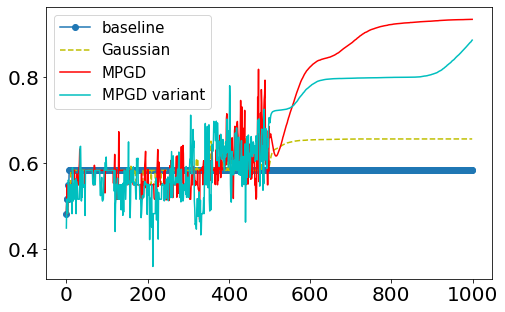

Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  3
gamma:  0.6 , beta:  0.0 , mu:  0.2 , sigma:  0.2
test accs:  [0.9526666666666667, 0.9126666666666666, 0.9426666666666667, 0.9293333333333333, 0.7884444444444444]
acc gaps:  [0.01533333333333331, 0.009333333333333416, -0.0006666666666667043, 0.00666666666666671, 0.003555555555555645]
Average test acc:  0.9051555555555555
Average acc gap:  0.006844444444444475
Std dev of test acc:  0.06694560164974929
Std dev of acc gap:  0.006031604008353022
Maximum test acc:  0.9526666666666667
Minimum test acc:  0.7884444444444444
Maximum acc gap:  0.01533333333333331
Minimum acc gap:  -0.0006666666666667043
--------------------------------------
Connected to a GPU
Number of trainable parameters: 

array([0.51675556, 0.51675556, 0.44973333, 0.48324444, 0.48324444,
       0.51675556, 0.48324444, 0.48324444, 0.48324444, 0.51653333,
       0.51675556, 0.51675556, 0.51675556, 0.51675556, 0.51675556,
       0.42844444, 0.48693333, 0.51675556, 0.48324444, 0.48328889,
       0.48324444, 0.44413333, 0.48324444, 0.51982222, 0.51675556,
       0.53253333, 0.48324444, 0.51675556, 0.51675556, 0.55026667,
       0.5804    , 0.48324444, 0.48324444, 0.48324444, 0.48324444,
       0.4496    , 0.48337778, 0.48742222, 0.5004    , 0.578     ,
       0.55026667, 0.51675556, 0.52111111, 0.49528889, 0.51777778,
       0.44973333, 0.48324444, 0.48324444, 0.49506667, 0.48582222,
       0.48902222, 0.44942222, 0.41617778, 0.44973333, 0.47155556,
       0.492     , 0.43844444, 0.53426667, 0.48213333, 0.48324444,
       0.53493333, 0.48333333, 0.45284444, 0.44973333, 0.44973333,
       0.45613333, 0.53542222, 0.4496    , 0.46995556, 0.46302222,
       0.45644444, 0.53515556, 0.48804444, 0.44951111, 0.41626

In [ ]:
# MPGD with beta = 0.0
print('==================== MPGD with beta = 0.0 ================== ')
sigma = 0.2
mu = 0.2
beta = 0.0
mean_acc_mpgd = run_exp(option=1, lr=lr, epochs=epochs, start_perturb=0, gamma=0.55, beta=beta, sigma=sigma, mu=mu, n_run=n_run)

# MPGD with perturbations of the form v(y1)-v(y2), where v is the observable and y1 and y2 are independent Thaler iterates
print('==== Another MPGD variant ===== ')
sigma = 0.2
mu = 0.2
beta = 0.0
mean_acc_mpgd_variant = run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.55, beta=beta, sigma=sigma, mu=mu, n_run=n_run)

# plotting the test accuracy results
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('font', size=13)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=15) 

plt.plot(mean_acc_baseline, '-o')
plt.plot(mean_acc_gaussian, '--y')
plt.plot(mean_acc_mpgd, '-r')
plt.plot(mean_acc_mpgd_variant, '-c')
plt.legend(['baseline', 'Gaussian', 'MPGD', 'MPGD variant'])
plt.show()

run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.60, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.65, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.70, beta=beta, sigma=sigma, mu=mu, n_run=n_run)

==================== MPGD with beta = 0.5 ================== 
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  1
gamma:  0.55 , beta:  0.5 , mu:  0.2 , sigma:  0.2
test accs:  [0.9437777777777778, 0.9397777777777778, 0.9471111111111111, 0.9484444444444444, 0.632]
acc gaps:  [0.012222222222222134, 0.004222222222222127, 0.010888888888888837, 0.013555555555555543, -0.0020000000000000018]
Average test acc:  0.8822222222222222
Average acc gap:  0.007777777777777728
Std dev of test acc:  0.13991858302792812
Std dev of acc gap:  0.006539528430916506
Maximum test acc:  0.9484444444444444
Minimum test acc:  0.632
Maximum acc gap:  0.013555555555555543
Minimum acc gap:  -0.0020000000000000018
--------------------------------------
Connected t

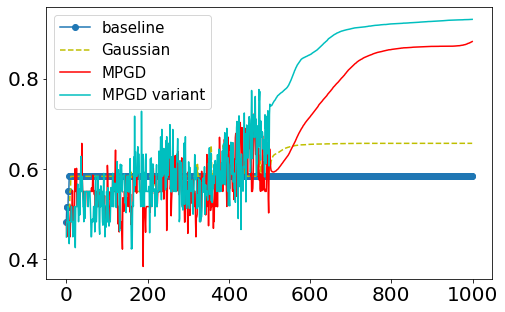

Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainable parameters:  5601
===========> Option:  3
gamma:  0.6 , beta:  0.5 , mu:  0.2 , sigma:  0.2
test accs:  [0.948, 0.876, 0.9333333333333333, 0.9284444444444444, 0.9026666666666666]
acc gaps:  [-0.008000000000000007, 0.0020000000000000018, 0.006666666666666599, -0.0004444444444443585, -0.004666666666666597]
Average test acc:  0.9176888888888889
Average acc gap:  -0.0008888888888888725
Std dev of test acc:  0.028472902430899203
Std dev of acc gap:  0.0057111543448428136
Maximum test acc:  0.948
Minimum test acc:  0.876
Maximum acc gap:  0.006666666666666599
Minimum acc gap:  -0.008000000000000007
--------------------------------------
Connected to a GPU
Number of trainable parameters:  5601
Connected to a GPU
Number of trainabl

array([0.55026667, 0.51675556, 0.55026667, 0.51675556, 0.48324444,
       0.48324444, 0.48324444, 0.48324444, 0.48324444, 0.48324444,
       0.48324444, 0.44973333, 0.44973333, 0.44973333, 0.48346667,
       0.48324444, 0.48324444, 0.48324444, 0.48324444, 0.48324444,
       0.48324444, 0.43773333, 0.44973333, 0.49204444, 0.50764444,
       0.5536    , 0.58377778, 0.58377778, 0.58377778, 0.58377778,
       0.58377778, 0.60484444, 0.55026667, 0.51675556, 0.48342222,
       0.5152    , 0.5168    , 0.51724444, 0.62084444, 0.51613333,
       0.51675556, 0.51675556, 0.5156    , 0.548     , 0.58377778,
       0.55026667, 0.55026667, 0.55026667, 0.55026667, 0.58946667,
       0.58386667, 0.55226667, 0.55026667, 0.51928889, 0.61511111,
       0.51675556, 0.55044444, 0.5504    , 0.58377778, 0.58391111,
       0.55084444, 0.65635556, 0.51675556, 0.51675556, 0.51675556,
       0.51675556, 0.51675556, 0.48324444, 0.48324444, 0.53315556,
       0.54831111, 0.53266667, 0.51675556, 0.54502222, 0.58377

In [6]:
# MPGD with beta = 0.5
print('==================== MPGD with beta = 0.5 ================== ')
sigma = 0.2
mu = 0.2
beta = 0.5
mean_acc_mpgd_beta05 = run_exp(option=1, lr=lr, epochs=epochs, start_perturb=0, gamma=0.55, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=1, lr=lr, epochs=epochs, start_perturb=0, gamma=0.60, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=1, lr=lr, epochs=epochs, start_perturb=0, gamma=0.65, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=1, lr=lr, epochs=epochs, start_perturb=0, gamma=0.70, beta=beta, sigma=sigma, mu=mu, n_run=n_run)

# MPGD with perturbations of the form v(y1)-v(y2), where v is the observable and y1 and y2 are independent Thaler iterates
print('==== Another MPGD variant ===== ')
sigma = 0.2
mu = 0.2
beta = 0.5
mean_acc_mpgd_variant_beta05 = run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.55, beta=beta, sigma=sigma, mu=mu, n_run=n_run)

# plotting the test accuracy results
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('font', size=13)
plt.rc('axes', titlesize=10) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('legend', fontsize=15) 

plt.plot(mean_acc_baseline, '-o')
plt.plot(mean_acc_gaussian, '--y')
plt.plot(mean_acc_mpgd_beta05, '-r')
plt.plot(mean_acc_mpgd_variant_beta05, '-c')
plt.legend(['baseline', 'Gaussian', 'MPGD', 'MPGD variant'])
plt.show()

run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.60, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.65, beta=beta, sigma=sigma, mu=mu, n_run=n_run)
run_exp(option=3, lr=lr, epochs=epochs, start_perturb=0, gamma=0.70, beta=beta, sigma=sigma, mu=mu, n_run=n_run)